In [ ]:
!pip install spacy

In [1]:
## Load data

import pandas as pd
import numpy as np
import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from collections import Counter
from nltk.tokenize import  word_tokenize
import pickle
import spacy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn import metrics

from joblib import dump, load

2023-05-25 23:45:52.295794: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 23:45:58.816604: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-25 23:45:58.818479: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [3]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

Available CPUs: 8
INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [4]:
%%time

df_news = pd.read_parquet('02_clean_df.parquet', engine='pyarrow')
df_news.shape

CPU times: user 1min 2s, sys: 10.5 s, total: 1min 13s
Wall time: 1min 9s


(198564, 7)

In [5]:
df_news['clean_text_sent'] = df_news['clean_text'].apply(lambda words: ' '.join(words))

In [6]:
df_news.sample(3)

,date,title,text,year_month,clean_text_case,clean_text,clean_title,clean_text_sent
21152,2023-03-17,Secoo Group: Officially Accesses OpenAI and ER...,Secoo Group: Officially Accesses OpenAI and ER...,2023-03,"[Secoo, Group, Officially, Accesses, OpenAI, E...","[secoo, group, officially, accesses, openai, e...",secoo group officially access openai ernie bot...,secoo group officially accesses openai ernie b...
169533,2022-07-24,Artificial Intelligence in Personalized Medici...,Artificial Intelligence in Personalized Medici...,2022-07,"[Artificial, Intelligence, Personalized, Medic...","[artificial, intelligence, personalized, medic...",artificial intelligence personalized medicine ...,artificial intelligence personalized medicine ...
11963,2021-12-16,French regulator tells Clearview AI to delete ...,\n\nFrench regulator tells Clearview AI to del...,2021-12,"[French, regulator, tell, Clearview, AI, delet...","[french, regulator, tell, clearview, ai, delet...",french regulator tell clearview ai delete faci...,french regulator tell clearview ai delete faci...


### Most Frequent Terms in our clean data

In [10]:
from nltk import FreqDist

# Assuming you have a DataFrame called 'df' and the column name is 'tokens'
all_tokens = [token for sublist in df_news['clean_text'] for token in sublist]

# Calculate the frequency distribution
freq_dist = FreqDist(all_tokens)

# Get the top 20 most frequent tokens
top_20_tokens = freq_dist.most_common(20)

# Print the top 20 tokens
for token, frequency in top_20_tokens:
    print(token, frequency)


ai 1763902
market 1431503
news 932503
data 714555
intelligence 677457
us 670017
new 654088
technology 639206
artificial 608100
business 588721
company 554645
report 519670
global 471869
industry 420743
research 387129
analysis 377434
said 334892
also 319732
learning 316282
growth 312685


## Customised Sentiment Analysis

### Using SVM on Yelp review data

In [11]:
directory = 'https://storage.googleapis.com/msca-bdp-data-open/yelp/'
fileName = 'yelp_train_sentiment.json'

path = directory + fileName

In [12]:
%%time

yelp = pd.read_json(path, orient='records', lines=True)
yelp.shape

CPU times: user 5.42 s, sys: 773 ms, total: 6.2 s
Wall time: 6.48 s


(255717, 3)

In [13]:
pd.set_option('display.max_colwidth', 200)

In [14]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255717 entries, 0 to 255716
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    255717 non-null  object
 1   label   255717 non-null  int64 
 2   lang    255717 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.9+ MB


In [15]:
yelp.nunique()

text     255649
label         2
lang          1
dtype: int64

In [16]:
# define X and y
X = yelp['text']
y = yelp['label']

print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (255717,)
y Shape: (255717,)


In [17]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(f"Training records, X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"Testing records, X_test: {X_test.shape} y_test: {y_test.shape}")

Training records, X_train: (191787,) y_train: (191787,)
Testing records, X_test: (63930,) y_test: (63930,)


### Initializing the Pipeline 

In [20]:
svm_pipeline = make_pipeline(
    CountVectorizer(lowercase=False, stop_words='english', ngram_range=(1,3)),
    SGDClassifier(max_iter=100, tol=None)
)

### Building and Evaluating Models

In [21]:
%time svm_pipeline.fit(X_train, y_train)

CPU times: user 3min 3s, sys: 5.65 s, total: 3min 9s
Wall time: 3min 7s


In [22]:
y_pred = svm_pipeline.predict(X_test)
print("Accuracy : ",round(metrics.accuracy_score(y_test, y_pred),2))
print(classification_report(y_test, y_pred))

Accuracy :  0.97
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     32003
           1       0.97      0.97      0.97     31927

    accuracy                           0.97     63930
   macro avg       0.97      0.97      0.97     63930
weighted avg       0.97      0.97      0.97     63930



In [23]:
%time dump(svm_pipeline, "svm_large.joblib")

CPU times: user 1min 19s, sys: 2.13 s, total: 1min 21s
Wall time: 1min 21s


['svm_large.joblib']

### Running the Yelp Trained Model on News data

In [9]:
%time clf_large = load('svm_large.joblib')

CPU times: user 43.4 s, sys: 3.13 s, total: 46.5 s
Wall time: 47.2 s


In [10]:
%time pred_sentiment = clf_large.predict(df_news['clean_text_sent'])
sent_class = np.where(pred_sentiment < 1, 'Negative', 'Positive')

CPU times: user 6min 35s, sys: 1.62 s, total: 6min 37s
Wall time: 6min 37s


In [11]:
df_news['sentiment_text'] = sent_class

In [12]:
df_news['sentiment_text'].value_counts()

Negative    167993
Positive     30571
Name: sentiment_text, dtype: int64

In [13]:
%time pred_sentiment_title = clf_large.predict(df_news['clean_title'])
sent_class_title = np.where(pred_sentiment_title < 1, 'Negative', 'Positive')

CPU times: user 6.93 s, sys: 15.5 ms, total: 6.95 s
Wall time: 6.95 s


In [14]:
df_news['sentiment_title'] = sent_class_title

In [16]:
df_news['sentiment_title'].value_counts()

Negative    164872
Positive     33692
Name: sentiment_title, dtype: int64

In [18]:
df_news.sample(5)

,date,title,text,year_month,clean_text_case,clean_text,clean_title,clean_text_sent,sentiment_text,sentiment_title
12375,2023-03-16,Cast AI raises $20M to help companies reduce c...,\n \n\n\nCast AI raises $20M to help companies...,2023-03,"[Cast, AI, raise, 20M, help, company, reduce, ...","[cast, ai, raise, 20m, help, company, reduce, ...",cast ai raise 20m help company reduce cloud sp...,cast ai raise 20m help company reduce cloud sp...,Negative,Negative
109156,2021-11-23,"Verbit, the World's Leading Voice AI Platform,...","Verbit, the World's Leading Voice AI Platform,...",2021-11,"[Verbit, World, Leading, Voice, AI, Platform, ...","[verbit, world, leading, voice, ai, platform, ...",verbit world leading voice ai platform raise 2...,verbit world leading voice ai platform raises ...,Positive,Positive
27814,2021-06-08,Preventing money mule fraud using artificial i...,Preventing money mule fraud using artificial i...,2021-06,"[Preventing, money, mule, fraud, using, artifi...","[preventing, money, mule, fraud, using, artifi...",preventing money mule fraud using artificial i...,preventing money mule fraud using artificial i...,Negative,Negative
199162,2023-03-07,Logoscapes.ai - Make your logo ✨incredible✨ w...,Logoscapes.ai - Make your logo ✨incredible✨ w...,2023-03,"[Logoscapesai, Make, logo, incredible, AI, Pro...","[logoscapesai, make, logo, incredible, ai, pro...",logoscapesai make logo ✨incredible✨ ai product...,logoscapesai make logo incredible ai product h...,Positive,Positive
193168,2021-07-02,Discover transforms data pipeline for AI succe...,\nDiscover transforms data pipeline for AI su...,2021-07,"[Discover, transforms, data, pipeline, AI, suc...","[discover, transforms, data, pipeline, ai, suc...",discover transforms data pipeline ai success cio,discover transforms data pipeline ai success c...,Negative,Negative


In [25]:
#saving with sentiment
df_news.to_parquet('03_sent_df.parquet')

In [4]:
%%time

df_news = pd.read_parquet('03_sent_svm_df.parquet', engine='pyarrow')
df_news.shape

CPU times: user 1min 4s, sys: 12.4 s, total: 1min 16s
Wall time: 1min 16s


(198564, 10)

In [5]:
print('Total number of rows: ',df_news.shape[0])

## Dropping duplicate news articles
df1 = df_news.drop_duplicates(subset=['clean_text_sent'], keep='first', inplace=False)
print('Drop text dups: ',df1.shape[0])

## Dropping news titles that report articles with the same sentiment
df2 = df1.drop_duplicates(subset=['title','sentiment_text'], keep='first', inplace=False)
print('Drop title, sentiment dups: ',df2.shape[0])

Total number of rows:  198564
Drop text dups:  197812
Drop title, sentiment dups:  141380


In [23]:
df2['sentiment_text'].value_counts()

Negative    121256
Positive     20124
Name: sentiment_text, dtype: int64

In [24]:
df_pos = df2[df2['sentiment_text'] == 'Positive']
df_neg = df2[df2['sentiment_text'] == 'Negative']

In [26]:
#saving with sentiment
df_pos.to_parquet('04_pos_df.parquet')
df_neg.to_parquet('05_neg_df.parquet')

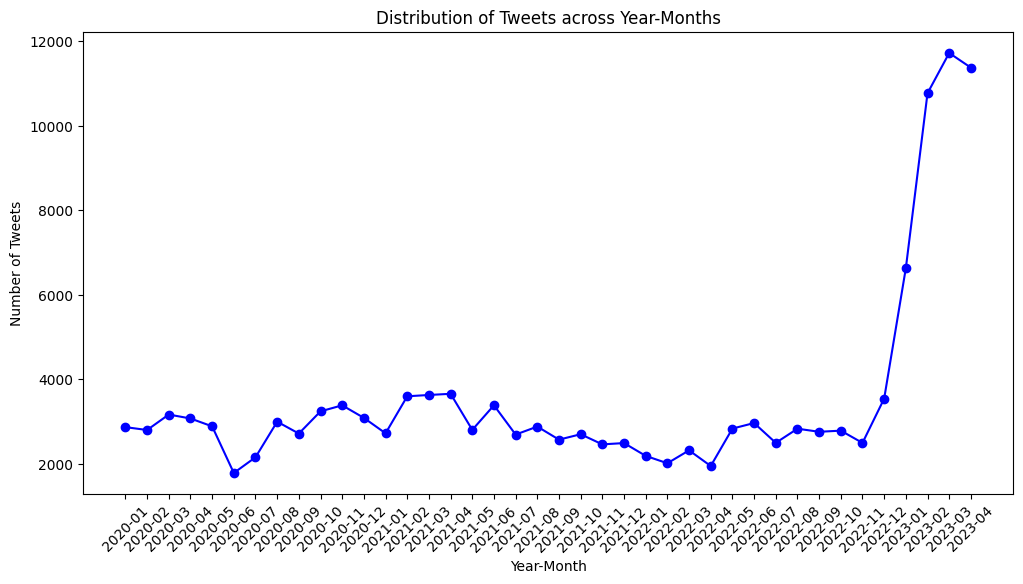

In [29]:
# Group the data by year-month and count the number of tweets
tweet_counts = df2.groupby('year_month').size()

# Convert the index to string representation
tweet_counts.index = tweet_counts.index.strftime('%Y-%m')

# Create a range of year-months for the x-axis tick labels
year_months = pd.period_range(start=min(df2['year_month']), end=max(df2['year_month']), freq='M')

# Convert year_months to string format
year_months_str = year_months.strftime('%Y-%m')

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the number of tweets
plt.plot(tweet_counts.index, tweet_counts.values, marker='o', linestyle='-', color='b')

# Set the x-axis tick positions and labels
plt.xticks(range(len(year_months_str)), year_months_str, rotation=45)

# Set the axis labels and title
plt.xlabel('Year-Month')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Tweets across Year-Months')

# Show the plot
plt.show()


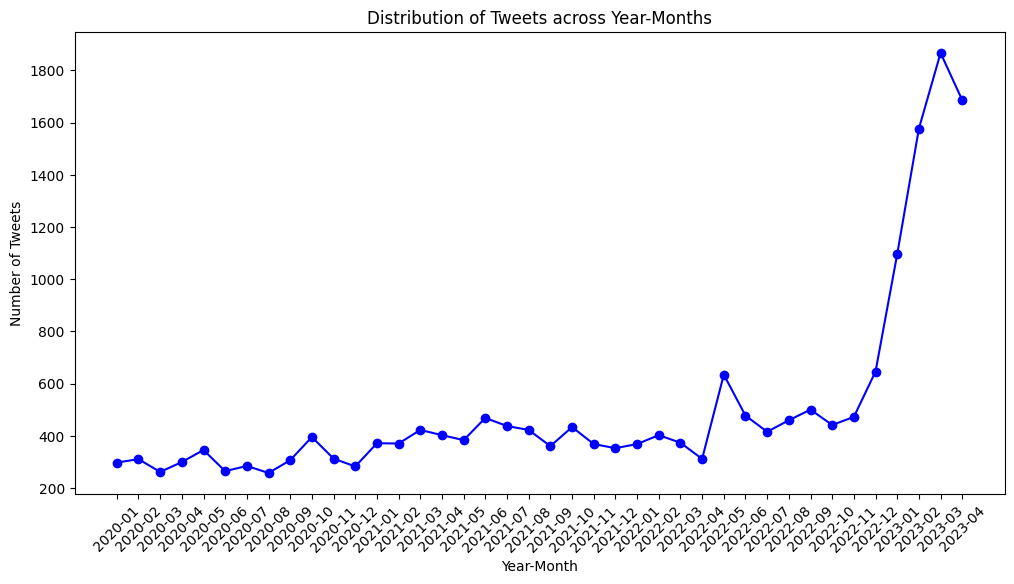

In [27]:
# Group the data by year-month and count the number of tweets
tweet_counts = df_pos.groupby('year_month').size()

# Convert the index to string representation
tweet_counts.index = tweet_counts.index.strftime('%Y-%m')

# Create a range of year-months for the x-axis tick labels
year_months = pd.period_range(start=min(df_pos['year_month']), end=max(df_pos['year_month']), freq='M')

# Convert year_months to string format
year_months_str = year_months.strftime('%Y-%m')

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the number of tweets
plt.plot(tweet_counts.index, tweet_counts.values, marker='o', linestyle='-', color='b')

# Set the x-axis tick positions and labels
plt.xticks(range(len(year_months_str)), year_months_str, rotation=45)

# Set the axis labels and title
plt.xlabel('Year-Month')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Tweets across Year-Months')

# Show the plot
plt.show()


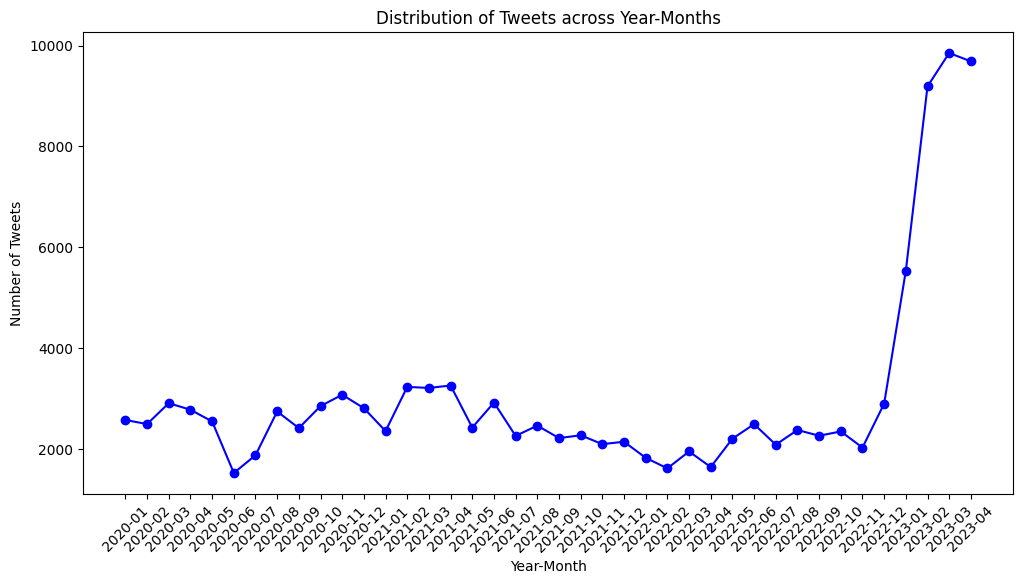

In [28]:
# Group the data by year-month and count the number of tweets
tweet_counts = df_neg.groupby('year_month').size()

# Convert the index to string representation
tweet_counts.index = tweet_counts.index.strftime('%Y-%m')

# Create a range of year-months for the x-axis tick labels
year_months = pd.period_range(start=min(df_neg['year_month']), end=max(df_neg['year_month']), freq='M')

# Convert year_months to string format
year_months_str = year_months.strftime('%Y-%m')

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the number of tweets
plt.plot(tweet_counts.index, tweet_counts.values, marker='o', linestyle='-', color='b')

# Set the x-axis tick positions and labels
plt.xticks(range(len(year_months_str)), year_months_str, rotation=45)

# Set the axis labels and title
plt.xlabel('Year-Month')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Tweets across Year-Months')

# Show the plot
plt.show()


## Zero Shot Classification

In [4]:
%%time

df_news = pd.read_parquet('03_sent_df.parquet', engine='pyarrow')
df_news.shape

CPU times: user 1min 23s, sys: 18.3 s, total: 1min 41s
Wall time: 1min 35s


(198564, 10)

In [30]:
from transformers import pipeline
import pandas as pd

# Load the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification")


No model was supplied, defaulted to roberta-large-mnli and revision 130fb28 (https://huggingface.co/roberta-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


2023-05-20 22:49:38.923935: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at roberta-large-mnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [34]:
!pip install tqdm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
%%time

from tqdm import tqdm

# Define the candidate labels
candidate_labels = ["technology", "non-technology"]

# Function to classify a single news text
def classify_text(text):
    result = classifier(text, candidate_labels)
    return result['labels'][0]

tqdm.pandas()

# Apply the classification to the dataframe
df2['zsc_topic'] = df2['clean_title'].progress_apply(classify_text)

# Print the dataframe
print(df2)

In [ ]:
df2['zsc_topic'].value_counts()